In [1]:
 !pip install PyWavelets

In [22]:
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime
import numpy as np
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, Dropout
from keras.optimizers import Adam

import pywt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import math

from scipy.stats import norm
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from scipy.stats import mode

import joblib
import matplotlib.dates as mdates
from google.colab import files

In [3]:
import random
import os
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

In [17]:
# Performance metrics

def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2

def calculate_mae(observed, predicted):
    mae = np.mean(np.abs(observed - predicted))
    return mae

def calculate_ca(rmse, mae, r2):
    ca = 0.33 * (rmse + mae + (1 - r2))
    return ca


In [5]:
from scipy.stats import levy_stable

In [6]:
def split_train_test(values, n_train_hours = 1460):
    # Split the data into train (use values before n_train_hours) and test sets (use values after n_train_hours)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features] required for LSTM
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return train_X, train_y, test_X, test_y

In [7]:
def build_lstm_model(input_shape, nb_neurons=95, learning_rate=0.1, dropout_rate=0.5):
    '''
    train and test: input shape 1 time step with 8 features
    LSTM:
     * nb_neurons: hidden state
     * 1 neuron for output layer for prediction.
    '''
    model = Sequential()

    # Add a GRU layer with nb_neurons, input_shape, and dropout
    model.add(GRU(nb_neurons, input_shape=input_shape))

    # Add a Dropout layer
    model.add(Dropout(dropout_rate))

    # Add a Dense layer with one output neuron
    model.add(Dense(1))

    # Compile the model with a specified learning rate for the Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)

    return model

def train_model(model, train_X, train_y, test_X, test_y, epochs=450, batch_size= 128, verbose=0):
  '''
  Generic function to train model
  '''
  history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=verbose, shuffle = True)
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

In [8]:
# invert scaling for forecast
def invert_scaling(scaled_X, scaled_yhat):
  scaled_X_reshaped = scaled_X.reshape((scaled_X.shape[0], scaled_X.shape[2]))
  Xyat = np.concatenate((scaled_X_reshaped, scaled_yhat.reshape(-1,1)), axis=1)
  inv_Xyat = scaler.inverse_transform(Xyat)
  return inv_Xyat[:,-1]

In [9]:
def history_and_horizon_sequencing(df, n_history, n_horizon, target='debits'):
    # Separate inputs (e.g., precipitation, ETP) from targets (e.g., discharge)
    input_columns = [col for col in df.columns if col != target]
    df_inputs = df[input_columns]
    df_target = df[target].to_frame()

    # History: past sequences (t-n, ... t-1) for inputs (e.g., precipitation, ETP)
    stack_history = []
    for i in range(n_history, 0, -1):
        df_i = df_inputs.shift(i)
        df_i.columns = [f'{col}_t-{i}' for col in df_i.columns]
        stack_history.append(df_i)

    # Present: t for inputs
    df_t = df_inputs.copy()
    df_t.columns = [f'{col}_t' for col in df_t.columns]

    # Horizon: future sequences (t+1, ... t+n) for targets (e.g., discharge)
    stack_horizon = []
    for j in range(0, n_horizon):
        df_j = df_target.shift(-j)
        df_j.columns = [f'{col}_t+{j}' for col in df_j.columns]
        stack_horizon.append(df_j)

    # Return the concatenated DataFrame: past + present + future (inputs and targets)
    return pd.concat(stack_history + [df_t] + stack_horizon, axis=1)

In [10]:
# Wavelet transform
def wavelet_transform(data, wavelet='coif1', level=6):
        coeffs = pywt.wavedec(data, wavelet, level=level)
        approx_coeffs = coeffs[0]
        transformed_data = pywt.waverec([approx_coeffs] + [None]*(len(coeffs)-1), wavelet)
        return transformed_data[:len(data)]

Simulation of HyMoLAP

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Bonou/calage_biao.xlsx')

discharge = daily.iloc[:1461, 0].to_numpy()
plui = daily.iloc[:1461, 1].to_numpy()
etp = daily.iloc[:1461, 2].to_numpy()


#Compute the Effective precipitation
prec_eff = plui - etp
prec_eff[prec_eff < 0] = 0

# X(t)
def state_basin(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]
    return X

#parameters obtained after Sto. HyMoLAP calibration
mu = 0.8136   # which is a in the paper
lambd = 2.9416   # which is b in the paper
sigma = 0.0035    # which is theta in the paper

# Lévy process parameters obtained after Sto. HyMoLAP calibration
alpha = 1.3
beta =  -0.8
gammaa = 1
delta = 0

# X(t)
X = state_basin(mu, lambd, prec_eff)

n_traj = 300000
QQ = np.zeros((len(discharge),n_traj))

for i in range(n_traj):

   #Simulate Lévy process
   Lev=[]
   Lev = levy_stable.rvs(alpha, beta, loc=delta, scale=gammaa, size=len(discharge))

   #Model
   S = np.zeros(len(discharge))
   S[0] = discharge[0]
   Phi = np.zeros(len(discharge))
   Phi[0] = prec_eff[0]
   for k in range(1, len(discharge)):
        if S[k - 1]<0:
          S[k - 1] = 0
        S[k] = S[k - 1] - (mu/lambd) * S[k-1]**(2*mu-1) + (1/lambd) * X[k-1] * prec_eff[k-1] + sigma * S[k - 1] * (Lev[k]-Lev[k - 1])

   QQ[:, i] = S.copy()

mean_trajectory = np.mean(QQ, axis=1)
var_trajectory = np.std(QQ, axis=1)**2
min_trajectory = pd.DataFrame(QQ).quantile(0.2, axis=1)        #np.min(QQ, axis=1)
max_trajectory =  pd.DataFrame(QQ).quantile(0.8, axis=1)       #np.max(QQ, axis=1)
diff = max_trajectory - min_trajectory



Validation HyMoLAP

In [13]:
discharge1 = daily.iloc[1461:, 0].to_numpy()
plui1 = daily.iloc[1461:, 1].to_numpy()
etp1 = daily.iloc[1461:, 2].to_numpy()

#Compute the Effective precipitation
plui_eff1 = plui1 - etp1
plui_eff1[plui_eff1 < 0] = 0



# Simulation with the SDE
size = len(discharge1)
n_traj = 300000
QQ = np.zeros((size,n_traj))

X = state_basin(mu, lambd, plui_eff1)

for i in range(n_traj):

   #Simulate Lévy process
   Lev=[]
   Lev = levy_stable.rvs(alpha, beta, loc=delta, scale=gammaa, size=size)

   # Model
   S = np.zeros(size)
   S[0] = discharge1[0]
   Phi1 = np.zeros(len(discharge1))
   Phi1[0] = plui_eff1[0]
   for k in range(1, size):
        if S[k - 1]<0:
          S[k - 1] = 0
        S[k] = S[k - 1] - (mu/lambd) * S[k-1]**(2*mu-1) + (1/lambd) * X[k-1] * plui_eff1[k-1] + sigma * S[k - 1] * (Lev[k]-Lev[k - 1])

   QQ[:, i] = S.copy()

mean_trajectory1 = np.mean(QQ, axis=1)
var_trajectory1 = np.std(QQ, axis=1)**2
min_trajectory1 = pd.DataFrame(QQ).quantile(0.2, axis=1)     #np.min(QQ, axis=1)
max_trajectory1 =  pd.DataFrame(QQ).quantile(0.8, axis=1)    #np.max(QQ, axis=1)
diff1 = max_trajectory1 - min_trajectory1


HYBRID

(1460, 1, 3) (1460,) (728, 1, 3) (728,)
(1460, 1, 3) (1460,) (728, 1, 3) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


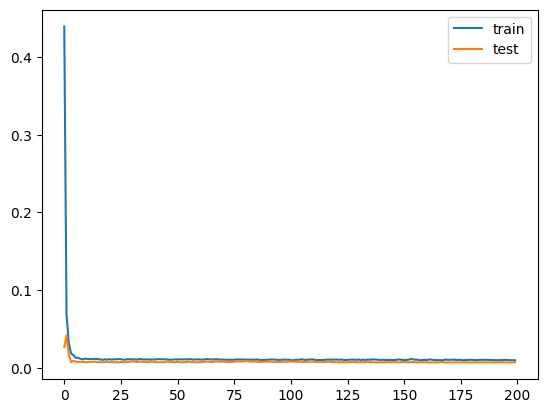

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [14]:
# Création du DataFrame pour l'entraînement (calibration)
data_train = pd.DataFrame({
    'mean_HyMoLAP': mean_trajectory[:-1],
    #'var_HyMoLAP': var_trajectory[:-1],
    #'diff_HyMoLAP': diff[:-1],
    #'mode_HyMoLAP': mode_trajectory[:-1],
    #'min_HyMoLAP': min_trajectory[:-1],
    #'max_HyMoLAP': max_trajectory[:-1],
    #'Phi_HyMoLAP': Phi[:-1],
    #'kurtosis_HyMoLAP': kurtosis_trajectory[:-1],
    #'skew_HyMoLAP': skewness_trajectory[:-1],
    #'autocorr_HyMoLAP': autocorr_trajectory[:-1],
    #'plui_HyMoLAP': plui[:-1],
    #'etp_HyMoLAP': etp[:-1],
    'target': discharge[1:]
})

# Création du DataFrame pour la validation (test)
data_test = pd.DataFrame({
    'mean_HyMoLAP': mean_trajectory1[:-1],  # Utilisez les mêmes noms de colonnes
    #'var_HyMoLAP': var_trajectory1[:-1],
    #'diff_HyMoLAP': diff1[:-1],
    #'mode_HyMoLAP': mode_trajectory1[:-1],
    #'min_HyMoLAP': min_trajectory1[:-1],
    #'max_HyMoLAP': max_trajectory1[:-1],
    #'Phi_HyMoLAP': Phi1[:-1],
    #'kurtosis_HyMoLAP': kurtosis_trajectory1[:-1],
    #'skew_HyMoLAP': skewness_trajectory1[:-1],
    #'autocorr_HyMoLAP': autocorr_trajectory1[:-1],
    #'plui_HyMoLAP': plui1[:-1],
    #'etp_HyMoLAP': etp1[:-1],
    'target': discharge1[1:]
})

# Concaténer les deux DataFrames (calibration + validation)
data = pd.concat([data_train, data_test], ignore_index=True)

#WAVELET TRANSFORM
# Exclure la dernière colonne ('target')
columns_to_transform = data.columns[:-1]  # Toutes les colonnes sauf la dernière
data_transformed = data[columns_to_transform].apply(lambda x: wavelet_transform(x, wavelet='db2', level=3), axis=0)

# Réattacher la colonne 'target' sans transformation
data_transformed['target'] = data['target']

# Conserver les noms de colonnes
data_transformed = pd.DataFrame(data_transformed, columns=data.columns)

# Convert to pd.Dataframe
data = pd.DataFrame(data_transformed)



#Include look_back
look_back = 2
horizon = 1
data_Xy = history_and_horizon_sequencing(data, look_back, horizon, target='target')
data_Xy.dropna(inplace=True)


#split data
train_X, train_y, test_X, test_y = split_train_test(data_Xy.values)


# Normalize features
values = data_Xy.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Create train/tests datasets from scaled_data
scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y = split_train_test(scaled_values)

# Build and train the model
input_shape=(scaled_train_X.shape[1], scaled_train_X.shape[2])
# Build
lstm_model_scaled = build_lstm_model(input_shape, nb_neurons=95, learning_rate=0.1, dropout_rate=0.5)
# Train
train_model(lstm_model_scaled, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs=200, batch_size= 128, verbose=0)


# make a prediction: Training
lstm_scaled_yhat = lstm_model_scaled.predict(scaled_train_X)
# invert_scaling
inv_yhat1 = invert_scaling(scaled_train_X, lstm_scaled_yhat)

# make a prediction: Test
lstm_scaled_yhat = lstm_model_scaled.predict(scaled_test_X)
# invert_scaling
inv_yhat = invert_scaling(scaled_test_X, lstm_scaled_yhat)


Performance for training

In [18]:
nse_value = nash_sutcliffe_efficiency(discharge[3:], inv_yhat1[:-2])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge[3:], inv_yhat1[:-2])
print('rmse=', rmse)

r2 = calculate_r2(discharge[3:], inv_yhat1[:-2])
print('r2=', r2)

mae = calculate_mae(discharge[3:], inv_yhat1[:-2])
print('mae=', mae)

print('CA=',calculate_ca(rmse, mae, r2))

Nash-Sutcliffe Efficiency (NSE): 0.8891296501211854
rmse= 89.84110432092923
r2= 0.89102331963778
mae= 52.2386082167161
CA= 46.92226744194249


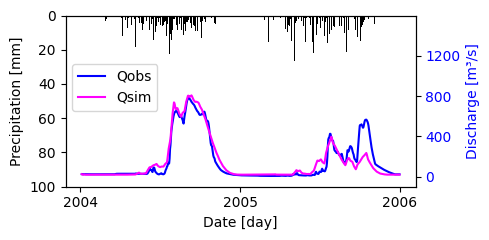

In [19]:
import matplotlib.dates as mdates

# Generate the date range
time1 = np.datetime64('2004-01-04')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')  # Daily date range

fig, ax1 = plt.subplots(figsize=(5., 2.5))

# Plot precipitation (plui1) as bars on ax1
ax1.bar(time, plui1[3:], color='black')

# Format the x-axis to display only the start of each year
ax1.xaxis.set_major_locator(mdates.YearLocator())  # One label per year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Date format 'YYYY'

# Align the date labels horizontally (no rotation)
plt.xticks(rotation=0)

# Label for the x-axis
ax1.set_xlabel('Date [day]')

# Parameters for the y-axis (precipitation)
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis for discharge (Qobs)
ax2 = ax1.twinx()
ax2.plot(time, discharge1[3:], 'b', label='Qobs')  # Plot observed discharge in blue

# Plot the mean trajectories (Qsim)
ax2.plot(time, inv_yhat, 'magenta', label='Qsim')  # Plot simulated discharge in magenta

# Parameters for the y-axis (discharge)
ax2.set_ylabel('Discharge [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-100, 1600)
ax2.set_yticks(np.arange(0, 1600, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.14, 0.75))

# Use tight_layout to avoid overlapping elements
plt.tight_layout()

# Save the plot as a .jpeg file
plt.savefig("sto_hyb_wgru1.jpeg", format='jpeg', dpi=300)

# Optional: Download the file
# files.download("sto_hyb_wgru1.jpeg")

# Display the plot
plt.show()


In [24]:
# Create a DataFrame to save the mean trajectory into an Excel file
df_mean_trajectory = pd.DataFrame({'Mean_Trajectory': inv_yhat})

# Save the DataFrame to an Excel file
df_mean_trajectory.to_excel('det_wgru.xlsx', index=False)

# Download the file in Google Colab
#files.download('det_wgru.xlsx')


In [23]:
nse_value = nash_sutcliffe_efficiency(discharge1[3:], inv_yhat)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1[3:], inv_yhat)
print('rmse=', rmse)

r2 = calculate_r2(discharge1[3:], inv_yhat)
print('r2=', r2)

mae = calculate_mae(discharge1[3:], inv_yhat)
print('mae=', mae)

print('CA=',calculate_ca(rmse, mae, r2))

Nash-Sutcliffe Efficiency (NSE): 0.8594837550827406
rmse= 81.03210505956007
r2= 0.863000085078985
mae= 46.32274474940457
CA= 42.072310408882274


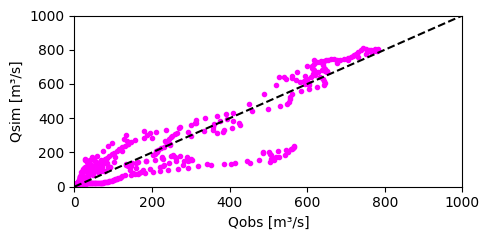

In [25]:
# Scatter plot of observed (Qobs) vs simulated (Qsim) values
plt.figure(figsize=(5, 2.5))
plt.scatter(discharge1[3:], inv_yhat, color='magenta', marker='.')  # Scatter plot of the values
plt.xlabel('Qobs [m³/s]')  # Label for the x-axis (observed discharge)
plt.ylabel('Qsim [m³/s]')  # Label for the y-axis (simulated discharge)

# Adjust the x and y-axis limits based on the data
plt.xlim(0, 1000)
plt.ylim(0, 1000)

# Add a reference line y=x (the perfect fit line)
plt.plot([0, 1000], [0, 1000], color='black', linestyle='--')

# Use tight_layout to avoid label clipping issues
plt.tight_layout()

# Save the plot as a .jpeg file before displaying it
plt.savefig("sca_sto_hyb_wgru1.jpeg", format='jpeg', dpi=300)

# Optional: Download the file to your laptop
# files.download("sca_sto_hyb_wgru1.jpeg")

# Now display the plot
plt.show()


Stacked model case

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


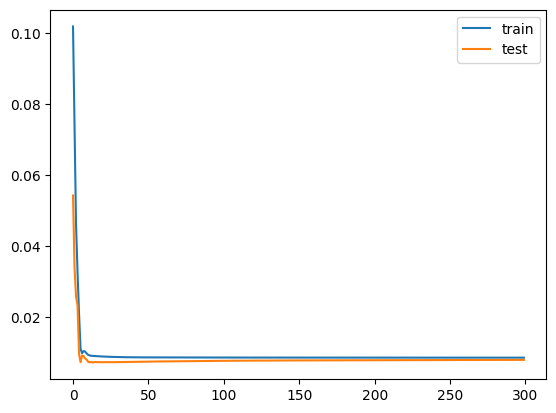

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [26]:
def build_stacked_gru_model(input_shape, nb_neurons=75):
    model = Sequential()
    model.add(GRU(nb_neurons, input_shape=input_shape, return_sequences=True))
    model.add(GRU(nb_neurons, return_sequences=True))
    #model.add(GRU(nb_neurons, return_sequences=True))
    model.add(GRU(nb_neurons, activation='relu'))
    model.add(Dense(1))
    return model

input_shape = (train_X.shape[1], train_X.shape[2])
# Build the new stacked_lstm_model
gru_model_new = build_stacked_gru_model(input_shape, nb_neurons=95)
# Train the model stacked_lstm_model
gru_model_new.compile(optimizer='adam', loss='mse')
train_model(gru_model_new, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs=300, batch_size= 256, verbose=0)

# make a prediction: Train
gru_scaled_yhat = gru_model_new.predict(scaled_train_X)
# invert_scaling
inv_yhat1 = invert_scaling(scaled_train_X, gru_scaled_yhat)

# make a prediction: Test
scaled_stacked_gru_yhat = gru_model_new.predict(scaled_test_X)
# invert_scaling
inv_yhat = invert_scaling(scaled_test_X, scaled_stacked_gru_yhat)

In [27]:
nse_value = nash_sutcliffe_efficiency(discharge1[3:], inv_yhat)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1[3:], inv_yhat)
print('rmse=', rmse)

r2 = calculate_r2(discharge1[3:], inv_yhat)
print('r2=', r2)

mae = calculate_mae(discharge1[3:], inv_yhat)
print('mae=', mae)

print('CA=',calculate_ca(rmse, mae, r2))

Nash-Sutcliffe Efficiency (NSE): 0.8426894823387571
rmse= 85.73787859256
r2= 0.8578000100625971
mae= 50.09486846347431
CA= 44.871732525170664
